In [3]:
import numpy as np
import networkx as nx
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

class Graph:
    def __init__(self, num_graphs_per_setting, n, radius, p):
        self.num_graphs_per_setting=num_graphs_per_setting
        self.n=n
        self.radius=radius
        self.p=p
        self.graphs = []
        self.graphs_radi=[]
        self.graphs_p=[]
        self.graphs_n=[]
        self.threshold=0.5

    def _generate_hybrid_graph(self,n,radius,p):
        graphs = []
        graphs_radi=[]
        graphs_p=[]
        graphs_n=[]
        for _ in range(self.num_graphs_per_setting):
            G = nx.random_geometric_graph(n, radius)
            for i in range(n):
                for j in range(i + 1, n):
                    if G.has_edge(i, j) and np.random.rand() > p:
                        G.remove_edge(i, j)
            graphs.append(G)
            graphs_radi.append(radius)
            graphs_p.append(p)
            graphs_n.append(n)
        return graphs,graphs_radi,graphs_p,graphs_n
        
    
    def generate_graph(self):
        for n in self.n:
            for p in self.p:
                for radius in self.radius:
                    one_set_of_graph,one_set_of_radi,one_set_of_p,one_set_of_n=self._generate_hybrid_graph(n, radius, p) 
                    self.graphs += one_set_of_graph
                    self.graphs_radi += one_set_of_radi
                    self.graphs_p += one_set_of_p
                    self.graphs_n += one_set_of_n
                    # one_set_of_result= compute_percolation_status(one_set_of_graph)
                    # result.append(np.sum(one_set_of_result)/num_graphs)
        
        # self.graphs=graphs
        # self.graph_radi=graphs_radi
        # self.graph_p=graphs_p
        

    def _compute_percolation_status(self):
        percolation_status = []
        for G in self.graphs:
            largest_cc = max(nx.connected_components(G), key=len)
            fraction_largest_cc = len(largest_cc) / len(G)
            percolation_status.append(int(fraction_largest_cc >= self.threshold))
        return np.array(percolation_status).reshape(-1, 1)

    def _extract_features(self,only_one_feature=False):
        avg_degree = []
        for G in self.graphs:
            avg_degree_one_set = np.mean(list(dict(G.degree()).values()))
            avg_degree.append(avg_degree_one_set)
        
        avg_degree=np.array(avg_degree)[:,np.newaxis]

        avg_n=np.array(self.graphs_n)[:,np.newaxis]
        avg_radi=np.array(self.graphs_radi)[:,np.newaxis]
        avg_p=np.array(self.graphs_p)[:,np.newaxis]

        if only_one_feature:
            return avg_degree
        else:
            feature=np.concatenate((avg_degree,avg_n,avg_radi,avg_p),axis=1)

        return feature
    
    def train(self, clf=SVC(kernel='linear'),ratio=0.5):
        X=self._extract_features()
        y=self._compute_percolation_status()
        X_sample, _, y_sample, _ = train_test_split(X, y, test_size=ratio, random_state=32)
        X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=10) 
        # clf = RandomForestClassifier(n_estimators=100, random_state=42)
        # clf = SVC(kernel='linear')
        # clf = KNeighborsClassifier(n_neighbors=2)
        clf.fit(X_train, y_train)
        return clf, X_test, y_test,X_train, y_train
    
    def evaluate(self,clf=SVC(kernel='linear'),ratio_range=np.linspace(0.1, 0.9, 9)):

        self.generate_graph()

        # size_range=np.linspace(1000, 3800, 4).astype(int)
        # ratio_range=1-size_range/4000

        accuracy_test=[]
        accuracy_train=[]
        for ratio in ratio_range:
            clf, X_test, y_test, X_train,y_train = self.train(clf, ratio)
            y_pred = clf.predict(X_test)
            accuracy_test.append(log_loss(y_test, y_pred))
            y_train_pred = clf.predict(X_train)
            accuracy_train.append(log_loss(y_train, y_train_pred))

        df = {
        'data_size': ratio_range*4000,
        'Training Accuracy': accuracy_train,
        'Testing Accuracy': accuracy_test
        }

        return pd.DataFrame(df)

n=np.linspace(100, 1000, 1).astype(int)
r=np.linspace(0.18, 0.22, 8)
p=np.linspace(0.18, 0.22, 5)
obj=Graph(100, n, r, p)

# obj.generate_graph()
# result=obj.compute_percolation_status()



# # print_evaluation(clf, X_test, y_test)
# print(f'size of the dataset is {len(result)}')
# print(f'percentage of data with target value: True {sum(result)/len(result)}')


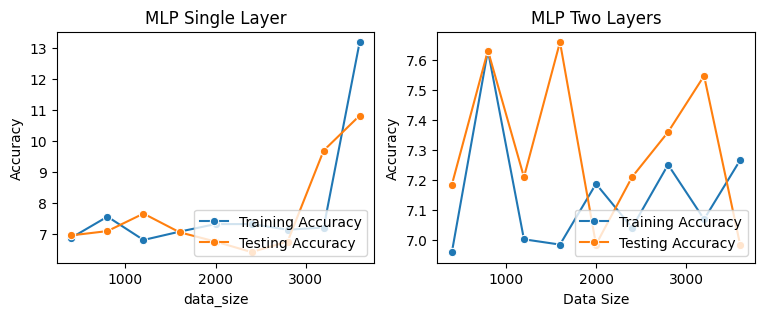

In [5]:
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns


# svc_mlp = obj.evaluate(MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam', max_iter=1000, random_state=19))
# svc_mlp_melted = svc_mlp.melt('data_size', var_name='MLP', value_name='Accuracy')

# svc_mlp = obj.evaluate(MLPClassifier(hidden_layer_sizes=(10,10), activation='relu', solver='adam', max_iter=1000, random_state=19))
# svc_mlp_melted_2 = svc_mlp.melt('data_size', var_name='MLP', value_name='Accuracy')

fig = plt.figure(figsize=(9,3))


ax1=fig.add_subplot(1,2,1)
sns.lineplot(data=svc_mlp_melted, x='data_size', y='Accuracy', hue='MLP', marker='o')
ax2=fig.add_subplot(1,2,2)
sns.lineplot(data=svc_mlp_melted_2, x='data_size', y='Accuracy', hue='MLP', marker='o')
plt.xlabel('Data Size')
plt.ylabel('Accuracy')

# plt.legend(title='Set')
# ax1.set_ylim(0, 1.1)
# ax2.set_ylim(0, 1.1)
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
ax1.set_title('MLP Single Layer')
ax2.set_title('MLP Two Layers')
plt.show()



In [37]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(obj, file)

# wandb.init(project="svc-percolation")

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import wandb
import pandas as pd
import matplotlib.pyplot as plt





def print_evaluation(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}\n")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))



def evaluate(clf, X, y):
    size_range=np.linspace(10, 3900, 5).astype(int)
    ratio_range=1-size_range/4000

    accuracy_test=[]
    accuracy_train=[]
    for ratio in ratio_range:
        clf, X_test, y_test, X_train,y_train = train_model(X, y,clf, ratio=0.5)
        y_pred = clf.predict(X_test)
        accuracy_test.append(accuracy_score(y_test, y_pred))
        y_train_pred = clf.predict(X_train)
        accuracy_train.append(accuracy_score(y_train, y_train_pred))

    df = {
    'data_size': size_range,
    'Training Accuracy': accuracy_train,
    'Testing Accuracy': accuracy_test
    }
    print_evaluation(clf, X_test, y_test)

    return pd.DataFrame(df)



    



In [39]:

import pandas as pd
import seaborn as sns
import warnings


# with open('model.pkl', 'rb') as file:
#     obj=pickle.load(file)
X=obj.extract_features(only_one_feature=False)
y=obj.compute_percolation_status()

### MLP classifier

Accuracy: 0.81

Confusion Matrix:
[[100  40]
 [ 36 224]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.72       140
           1       0.85      0.86      0.85       260

    accuracy                           0.81       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.81      0.81      0.81       400

Accuracy: 0.76

Confusion Matrix:
[[ 46  94]
 [  2 258]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.33      0.49       140
           1       0.73      0.99      0.84       260

    accuracy                           0.76       400
   macro avg       0.85      0.66      0.67       400
weighted avg       0.81      0.76      0.72       400



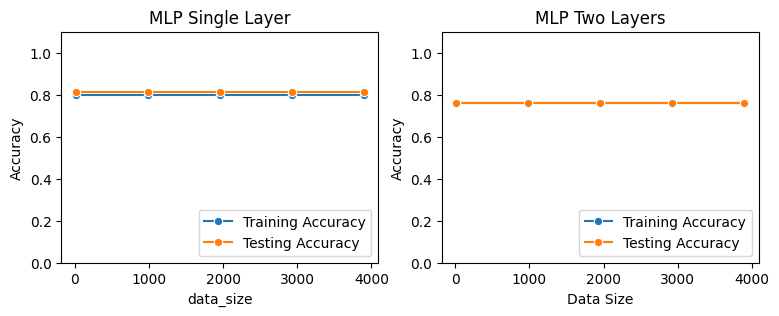

Accuracy: 0.79

Confusion Matrix:
[[ 87  53]
 [ 31 229]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.62      0.67       140
           1       0.81      0.88      0.85       260

    accuracy                           0.79       400
   macro avg       0.77      0.75      0.76       400
weighted avg       0.79      0.79      0.79       400

Accuracy: 0.65

Confusion Matrix:
[[  0 140]
 [  0 260]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       140
           1       0.65      1.00      0.79       260

    accuracy                           0.65       400
   macro avg       0.33      0.50      0.39       400
weighted avg       0.42      0.65      0.51       400



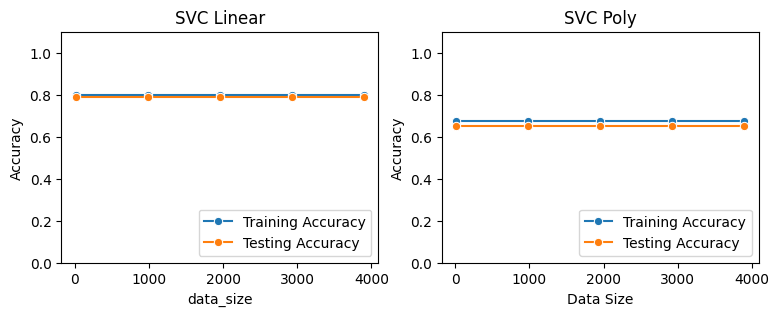

In [41]:



svc_linear = evaluate(SVC(kernel='linear'), X, y)
svc_linear_melted = svc_linear.melt('data_size', var_name='SVC', value_name='Accuracy')

svc_poly = evaluate(SVC(kernel='poly',degree=2), X, y)
svc_poly_melted = svc_poly.melt('data_size', var_name='SVC', value_name='Accuracy')

fig = plt.figure(figsize=(9,3))


ax1=fig.add_subplot(1,2,1)
sns.lineplot(data=svc_linear_melted, x='data_size', y='Accuracy', hue='SVC', marker='o')
ax2=fig.add_subplot(1,2,2)
sns.lineplot(data=svc_poly_melted, x='data_size', y='Accuracy', hue='SVC', marker='o')
plt.xlabel('Data Size')
plt.ylabel('Accuracy')

# plt.legend(title='Set')
ax1.set_ylim(0, 1.1)
ax2.set_ylim(0, 1.1)
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
ax1.set_title('SVC Linear')
ax2.set_title('SVC Poly')
plt.show()

Accuracy: 0.68

Confusion Matrix:
[[100  40]
 [ 88 172]]

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.71      0.61       140
           1       0.81      0.66      0.73       260

    accuracy                           0.68       400
   macro avg       0.67      0.69      0.67       400
weighted avg       0.71      0.68      0.69       400

Accuracy: 0.79

Confusion Matrix:
[[ 91  49]
 [ 36 224]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.65      0.68       140
           1       0.82      0.86      0.84       260

    accuracy                           0.79       400
   macro avg       0.77      0.76      0.76       400
weighted avg       0.78      0.79      0.78       400



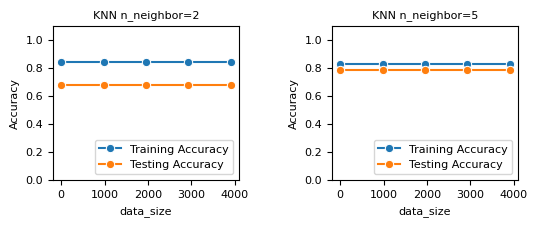

In [63]:



svc_linear = evaluate(KNeighborsClassifier(n_neighbors=2), X, y)
svc_linear_melted = svc_linear.melt('data_size', var_name='SVC', value_name='Accuracy')

svc_poly = evaluate(KNeighborsClassifier(n_neighbors=5), X, y)
svc_poly_melted = svc_poly.melt('data_size', var_name='SVC', value_name='Accuracy')

fig = plt.figure(figsize=(6,2))
plt.subplots_adjust(wspace=0.5) 

ax1=fig.add_subplot(1,2,1)
sns.lineplot(data=svc_linear_melted, x='data_size', y='Accuracy', hue='SVC', marker='o')
ax2=fig.add_subplot(1,2,2)
sns.lineplot(data=svc_poly_melted, x='data_size', y='Accuracy', hue='SVC', marker='o')
# plt.xlabel('Data Size')
# plt.ylabel('Accuracy')



plt.rcParams.update({
    'font.size': 8,          # General font size
    'axes.titlesize': 8,     # Font size for titles
    'axes.labelsize': 8,     # Font size for x and y labels
    # 'xtick.labelsize': 8,    # Font size for x-axis tick labels
    # 'ytick.labelsize': 8,    # Font size for y-axis tick labels
    'legend.fontsize': 8     # Font size for legend
})

# plt.legend(title='Set')
ax1.set_ylim(0, 1.1)
ax2.set_ylim(0, 1.1)
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
ax1.set_title('KNN n_neighbor=2')
ax2.set_title('KNN n_neighbor=5')
plt.savefig('knn.pdf')
plt.show()

Accuracy: 0.72

Confusion Matrix:
[[ 76  64]
 [ 49 211]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.54      0.57       140
           1       0.77      0.81      0.79       260

    accuracy                           0.72       400
   macro avg       0.69      0.68      0.68       400
weighted avg       0.71      0.72      0.71       400

Accuracy: 0.68

Confusion Matrix:
[[100  40]
 [ 88 172]]

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.71      0.61       140
           1       0.81      0.66      0.73       260

    accuracy                           0.68       400
   macro avg       0.67      0.69      0.67       400
weighted avg       0.71      0.68      0.69       400

Accuracy: 0.76

Confusion Matrix:
[[ 85  55]
 [ 42 218]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.61      0.64     

([<matplotlib.axis.XTick at 0x7fc092adb7d0>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(11, 0, '11')])

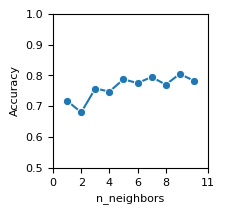

In [80]:
n_range=np.linspace(1, 10, 10).astype(int)
accuracy=[]
for n in n_range:
    knn = evaluate(KNeighborsClassifier(n_neighbors=n), X, y)
    accuracy.append(knn['Testing Accuracy'].mean())

fig = plt.figure(figsize=(2,2))
sns.lineplot(x=n_range,y=accuracy, marker='o')
plt.rcParams.update({
    'font.size': 8,          # General font size
    'axes.titlesize': 8,     # Font size for titles
    'axes.labelsize': 8,     # Font size for x and y labels
    # 'xtick.labelsize': 8,    # Font size for x-axis tick labels
    # 'ytick.labelsize': 8,    # Font size for y-axis tick labels
    'legend.fontsize': 8     # Font size for legend
})
plt.ylim(0.5, 1.)
plt.xlim(0, 8.)
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.xticks([0,2,4,6,8,11])

In [82]:
n_range=['linear','poly','rbf','sigmoid']
accuracy=[]
for n in n_range:
    knn = evaluate(SVC(kernel=n), X, y)
    accuracy.append(knn['Testing Accuracy'].mean())




tabela= pd.DataFrame({
    'Kernel':n_range,
    'Accuracy':accuracy,
})
display(tabela)

# fig = plt.figure(figsize=(2,2))
# sns.lineplot(x=n_range,y=accuracy, marker='o')
# plt.rcParams.update({
#     'font.size': 8,          # General font size
#     'axes.titlesize': 8,     # Font size for titles
#     'axes.labelsize': 8,     # Font size for x and y labels
#     # 'xtick.labelsize': 8,    # Font size for x-axis tick labels
#     # 'ytick.labelsize': 8,    # Font size for y-axis tick labels
#     'legend.fontsize': 8     # Font size for legend
# })
# plt.ylim(0.5, 1.)
# plt.xlim(0, 8.)
# plt.xlabel('n_neighbors')
# plt.ylabel('Accuracy')
# plt.xticks([0,2,4,6,8,11])

Accuracy: 0.79

Confusion Matrix:
[[ 87  53]
 [ 31 229]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.62      0.67       140
           1       0.81      0.88      0.85       260

    accuracy                           0.79       400
   macro avg       0.77      0.75      0.76       400
weighted avg       0.79      0.79      0.79       400

Accuracy: 0.65

Confusion Matrix:
[[  0 140]
 [  0 260]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       140
           1       0.65      1.00      0.79       260

    accuracy                           0.65       400
   macro avg       0.33      0.50      0.39       400
weighted avg       0.42      0.65      0.51       400

Accuracy: 0.65

Confusion Matrix:
[[  0 140]
 [  0 260]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     

,Kernel,Accuracy
0,linear,0.79
1,poly,0.65
2,rbf,0.65
3,sigmoid,0.65


In [84]:
n_range=['logistic', 'identity', 'relu', 'tanh']
accuracy=[]
for n in n_range:
    knn = evaluate(MLPClassifier(hidden_layer_sizes=(100), activation=n, solver='adam', max_iter=1000, random_state=19), X, y)
    accuracy.append(knn['Testing Accuracy'].mean())


tabela= pd.DataFrame({
    'Kernel':n_range,
    'Accuracy':accuracy,
})
display(tabela)

# fig = plt.figure(figsize=(2,2))
# sns.lineplot(x=n_range,y=accuracy, marker='o')
# plt.rcParams.update({
#     'font.size': 8,          # General font size
#     'axes.titlesize': 8,     # Font size for titles
#     'axes.labelsize': 8,     # Font size for x and y labels
#     # 'xtick.labelsize': 8,    # Font size for x-axis tick labels
#     # 'ytick.labelsize': 8,    # Font size for y-axis tick labels
#     'legend.fontsize': 8     # Font size for legend
# })
# plt.ylim(0.5, 1.)
# plt.xlim(0, 8.)
# plt.xlabel('n_neighbors')
# plt.ylabel('Accuracy')
# plt.xticks([0,2,4,6,8,11])

Accuracy: 0.81

Confusion Matrix:
[[100  40]
 [ 36 224]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.72       140
           1       0.85      0.86      0.85       260

    accuracy                           0.81       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.81      0.81      0.81       400

Accuracy: 0.76

Confusion Matrix:
[[ 51  89]
 [  6 254]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.36      0.52       140
           1       0.74      0.98      0.84       260

    accuracy                           0.76       400
   macro avg       0.82      0.67      0.68       400
weighted avg       0.79      0.76      0.73       400

Accuracy: 0.81

Confusion Matrix:
[[100  40]
 [ 36 224]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.72     

,Kernel,Accuracy
0,logistic,0.8100
1,identity,0.7625
2,relu,0.8100
3,tanh,0.8100
